<a href="https://colab.research.google.com/github/MouseLand/suite2p/blob/main/jupyter/run_suite2p_colab_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install suite2p

In [2]:
import os, requests
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import suite2p

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [3]:
# Figure Style settings for notebook.
import matplotlib as mpl
mpl.rcParams.update({
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'figure.subplot.wspace': .01,
    'figure.subplot.hspace': .01,
    'figure.figsize': (18, 13),
    'ytick.major.left': True,
})
jet = mpl.cm.get_cmap('jet')
jet.set_bad(color='k')

# Running suite2p on example data

This notebook will guide you through the various stages and outputs of suite2p by running it on a real-life dataset. This is data collected from a wild-type mouse injected with GCaMP6s in primary visual cortex. The recording was collected at 13Hz (there were 3 planes in the recording, 1 is included here).

The next code cell downloads the data. You can also upload your own data to this folder on the left in the "Files" menu, or you can connect to your google drive (see instructions [here](https://colab.research.google.com/notebooks/io.ipynb)), which will make it easier to download the output files to your local computer.


In [4]:
fname = "gt1.tif"
url = "https://www.suite2p.org/test_data/gt1.tif"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

from tifffile import imread
data = imread(fname)
print('imaging data of shape: ', data.shape)
n_time, Ly, Lx = data.shape

imaging data of shape:  (4500, 325, 556)


## Set pipeline parameters

You can find an explanation of each op parameters [here](https://suite2p.readthedocs.io/en/latest/settings.html).

In [5]:
ops = suite2p.default_ops()
ops['batch_size'] = 200 # we will decrease the batch_size in case low RAM on computer
ops['threshold_scaling'] = 2.0 # we are increasing the threshold for finding ROIs to limit the number of non-cell ROIs found (sometimes useful in gcamp injections)
ops['fs'] = 13 # sampling rate of recording, determines binning for cell detection
ops['tau'] = 1.25 # timescale of gcamp to use for deconvolution
print(ops)

{'suite2p_version': '0.10.1', 'look_one_level_down': False, 'fast_disk': [], 'delete_bin': False, 'mesoscan': False, 'bruker': False, 'bruker_bidirectional': False, 'h5py': [], 'h5py_key': 'data', 'save_path0': [], 'save_folder': [], 'subfolders': [], 'move_bin': False, 'nplanes': 1, 'nchannels': 1, 'functional_chan': 1, 'tau': 1.25, 'fs': 13, 'force_sktiff': False, 'frames_include': -1, 'multiplane_parallel': False, 'ignore_flyback': [], 'preclassify': 0.0, 'save_mat': False, 'save_NWB': False, 'combined': True, 'aspect': 1.0, 'do_bidiphase': False, 'bidiphase': 0, 'bidi_corrected': False, 'do_registration': 1, 'two_step_registration': False, 'keep_movie_raw': False, 'nimg_init': 300, 'batch_size': 200, 'maxregshift': 0.1, 'align_by_chan': 1, 'reg_tif': False, 'reg_tif_chan2': False, 'subpixel': 10, 'smooth_sigma_time': 0, 'smooth_sigma': 1.15, 'th_badframes': 1.0, 'norm_frames': True, 'force_refImg': False, 'pad_fft': False, 'nonrigid': True, 'block_size': [128, 128], 'snr_thresh': 1

## Set Data Path
`ops` and `db` are functionally equivalent internally in suite2p, with the exception that parameters provided in `db` will overwrite parameters specified in `ops`.

**Tip**:  Since it's common to change datasets and keep the same parameters for each dataset, some might find it useful to specify data-related arguments in `db` and pipeline parameters in `ops`. 

In [6]:
db = {
    'data_path': [os.getcwd()],
}
print(db)

{'data_path': ['/content']}


## Run Suite2p on Data

The `suite2p.run_s2p` function runs the pipeline and returns a list of output dictionaries containing the pipeline parameters used and extra data calculated along the way, one for each plane.

In [7]:
output_ops = suite2p.run_s2p(ops=ops, db=db)

{'data_path': ['/content']}
tif
** Found 1 tifs - converting to binary **
800 frames of binary, time 1.16 sec.
1600 frames of binary, time 2.16 sec.
2400 frames of binary, time 3.56 sec.
3200 frames of binary, time 4.45 sec.
4000 frames of binary, time 5.54 sec.
time 6.46 sec. Wrote 4500 frames per binary for 1 planes
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
----------- REGISTRATION
registering 4500 frames
Reference frame, 40.03 sec.
Registered 800/4500 in 40.17s
Registered 1600/4500 in 79.74s
Registered 2400/4500 in 118.08s
Registered 3200/4500 in 156.12s
Registered 4000/4500 in 194.17s
added enhanced mean image
----------- Total 267.85 sec
Registration metrics, 21.60 sec.
NOTE: Applying builtin classifier at /usr/local/lib/python3.7/dist-packages/suite2p/classifiers/classifier.npy
----------- ROI DETECTION
Binning movie in chunks of length 16
Binned movie [279,31

/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'cell_ipix' of function 'matmul_traces'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../usr/local/lib/python3.7/dist-packages/suite2p/extraction/extract.py", line 105:
@njit(parallel=True)
def matmul_traces(Fi, data, cell_ipix, cell_lam):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'cell_lam' of function 'matmul_traces'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-a

Extracted fluorescence from 2372 ROIs in 4500 frames, 40.13 sec.
----------- Total 43.73 sec.
----------- CLASSIFICATION
['npix_norm', 'skew', 'compact']
----------- Total 0.08 sec.
----------- SPIKE DECONVOLUTION
----------- Total 1.17 sec.
Plane 0 processed in 370.05 sec (can open in GUI).
total = 376.63 sec.
TOTAL RUNTIME 376.64 sec


### Outputs from the Suite2p Pipeline

#### Ops dictionaries

The ops dictionary contains all the keys that went into the analysis, plus new keys that contain additional metrics/outputs calculated during the pipeline run.

In [8]:
print(set(output_ops.keys()).difference(ops.keys()))

{'save_path', 'yblock', 'date_proc', 'corrXY1', 'xblock', 'Vmax', 'Ly', 'nframes', 'Vsplit', 'frames_per_folder', 'rmax', 'Lxc', 'reg_file', 'corrXY', 'frames_per_file', 'ops_path', 'regDX', 'spatscale_pix', 'Lx', 'rmin', 'Vmap', 'nblocks', 'xoff', 'meanImg', 'regPC', 'yoff1', 'data_path', 'max_proj', 'NRsm', 'xoff1', 'Lyc', 'ihop', 'yrange', 'xrange', 'Vcorr', 'tPC', 'filelist', 'meanImgE', 'yoff', 'refImg', 'first_tiffs', 'input_format', 'badframes', 'timing'}


#### Results Files

In [9]:
list(Path(output_ops['save_path']).iterdir())

[PosixPath('/content/suite2p/plane0/Fneu.npy'),
 PosixPath('/content/suite2p/plane0/spks.npy'),
 PosixPath('/content/suite2p/plane0/.ipynb_checkpoints'),
 PosixPath('/content/suite2p/plane0/stat.npy'),
 PosixPath('/content/suite2p/plane0/F.npy'),
 PosixPath('/content/suite2p/plane0/ops.npy'),
 PosixPath('/content/suite2p/plane0/data.bin'),
 PosixPath('/content/suite2p/plane0/iscell.npy')]

The output parameters can also be found in the "ops.npy" file.  This is especially useful when running the pipeline from the terminal or the graphical interface.  It contains the same data that is output from the python `run_s2p()` function.

In [10]:
output_ops_file = np.load(Path(output_ops['save_path']).joinpath('ops.npy'), allow_pickle=True).item()
output_ops_file.keys() == output_ops.keys()

True

The other files will be used for the visualizations below.

## Visualizations

### Registration

Registration computes a reference image from a subset of frames and registers all frames to the reference. 

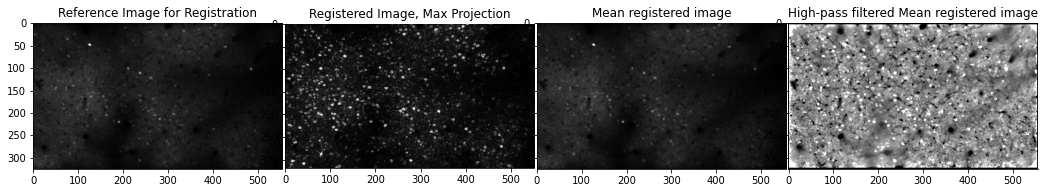

In [11]:
plt.subplot(1, 4, 1)

plt.imshow(output_ops['refImg'], cmap='gray', )
plt.title("Reference Image for Registration");

# maximum of recording over time
plt.subplot(1, 4, 2)
plt.imshow(output_ops['max_proj'], cmap='gray')
plt.title("Registered Image, Max Projection");

plt.subplot(1, 4, 3)
plt.imshow(output_ops['meanImg'], cmap='gray')
plt.title("Mean registered image")

plt.subplot(1, 4, 4)
plt.imshow(output_ops['meanImgE'], cmap='gray')
plt.title("High-pass filtered Mean registered image");

The rigid offsets of the frame from the reference are saved in `output_ops['yoff']` and `output_ops['xoff']`. The nonrigid offsets are saved in `output_ops['yoff1']` and `output_ops['xoff1']`, and each column is the offsets for a block (128 x 128 pixels by default).

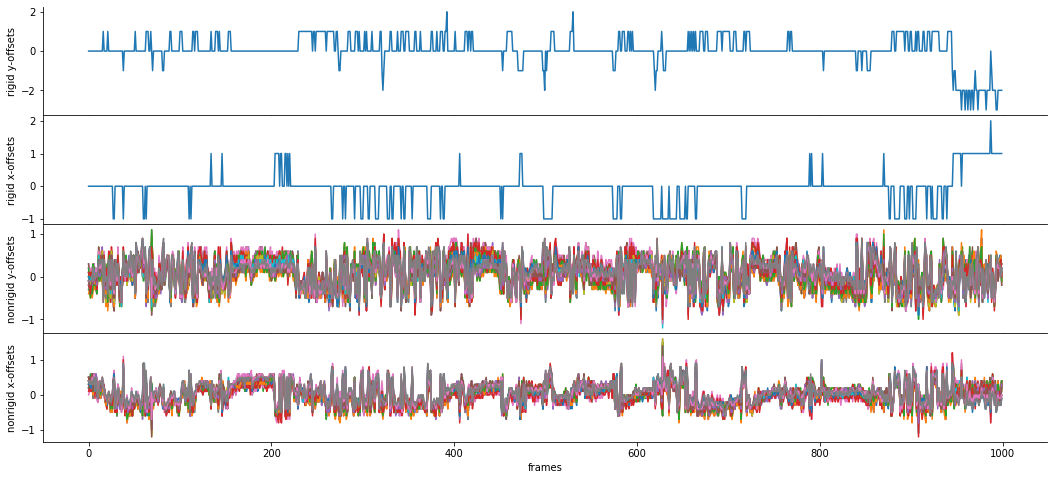

In [12]:
plt.figure(figsize=(18,8))

plt.subplot(4,1,1)
plt.plot(output_ops['yoff'][:1000])
plt.ylabel('rigid y-offsets')

plt.subplot(4,1,2)
plt.plot(output_ops['xoff'][:1000])
plt.ylabel('rigid x-offsets')

plt.subplot(4,1,3)
plt.plot(output_ops['yoff1'][:1000])
plt.ylabel('nonrigid y-offsets')

plt.subplot(4,1,4)
plt.plot(output_ops['xoff1'][:1000])
plt.ylabel('nonrigid x-offsets')
plt.xlabel('frames')

plt.show()


In [13]:
#@title Run cell to look at registered frames
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from suite2p.io import BinaryFile

widget = widgets.IntSlider(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)


def plot_frame(t):
    with BinaryFile(Ly=output_ops['Ly'],
                Lx=output_ops['Lx'],
                read_filename=output_ops['reg_file']) as f:
        plt.imshow(f[t][0])

interact(plot_frame, t=(0, output_ops['nframes'], 1));

interactive(children=(IntSlider(value=2250, description='t', max=4500), Output()), _dom_classes=('widget-inter…

Here in the notebook is not the best/fastest way to play the movie, you can play it in the suite2p GUI in the "View registered binary" player.

### Detection

ROIs are found by searching for sparse signals that are correlated spatially in the FOV. The ROIs are saved in `stat.npy` as a list of dictionaries which contain the pixels of the ROI and their weights (`stat['ypix']`, `stat['xpix']`, and `stat['lam']`). It also contains other spatial properties of the ROIs such as their aspect ratio and compactness, and properties of the signal such as the skewness of the fluorescence signal.


In [14]:
stats_file = Path(output_ops['save_path']).joinpath('stat.npy')
iscell = np.load(Path(output_ops['save_path']).joinpath('iscell.npy'), allow_pickle=True)[:, 0].astype(int)
stats = np.load(stats_file, allow_pickle=True)
print(stats[0].keys())

dict_keys(['ypix', 'xpix', 'lam', 'med', 'footprint', 'mrs', 'mrs0', 'compact', 'solidity', 'npix', 'npix_soma', 'soma_crop', 'overlap', 'radius', 'aspect_ratio', 'npix_norm_no_crop', 'npix_norm', 'skew', 'std', 'neuropil_mask'])


Some ROIs are defined as "cells" (somatic ROIs) or "not cells" (all other ROIs) depending on their properties, like skewness, compactness, etc. Below we will visualize the ROIs, but please open the files in the suite2p GUI for closer inspection.

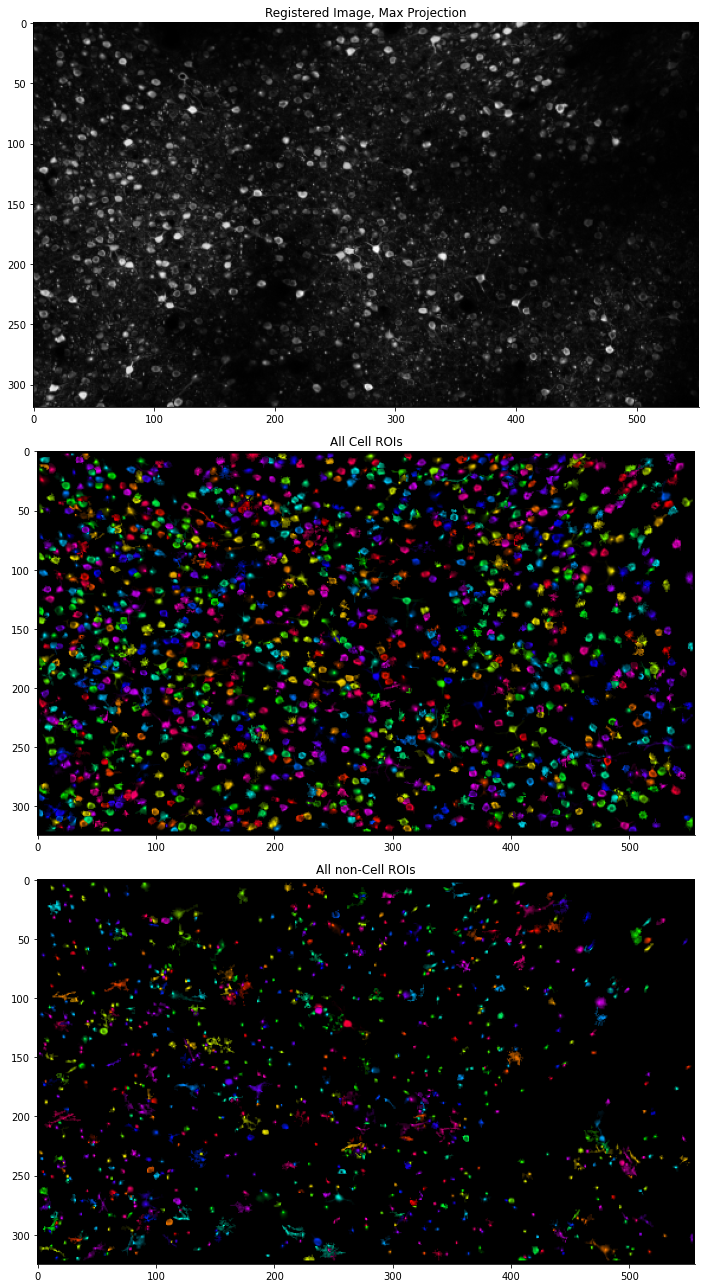

In [15]:
n_cells = len(stats)

h = np.random.rand(n_cells)
hsvs = np.zeros((2, Ly, Lx, 3), dtype=np.float32)

for i, stat in enumerate(stats):
    ypix, xpix, lam = stat['ypix'], stat['xpix'], stat['lam']
    hsvs[iscell[i], ypix, xpix, 0] = h[i]
    hsvs[iscell[i], ypix, xpix, 1] = 1
    hsvs[iscell[i], ypix, xpix, 2] = lam / lam.max()

from colorsys import hsv_to_rgb
rgbs = np.array([hsv_to_rgb(*hsv) for hsv in hsvs.reshape(-1, 3)]).reshape(hsvs.shape)

plt.figure(figsize=(18,18))
plt.subplot(3, 1, 1)
plt.imshow(output_ops['max_proj'], cmap='gray')
plt.title("Registered Image, Max Projection")

plt.subplot(3, 1, 2)
plt.imshow(rgbs[1])
plt.title("All Cell ROIs")

plt.subplot(3, 1, 3)
plt.imshow(rgbs[0])
plt.title("All non-Cell ROIs");

plt.tight_layout()

### Traces

We will load in the fluorescence, the neuropil and the deconvolved traces, and visualize them for a few cells.

In [16]:
f_cells = np.load(Path(output_ops['save_path']).joinpath('F.npy'))
f_neuropils = np.load(Path(output_ops['save_path']).joinpath('Fneu.npy'))
spks = np.load(Path(output_ops['save_path']).joinpath('spks.npy'))
f_cells.shape, f_neuropils.shape, spks.shape

((2372, 4500), (2372, 4500), (2372, 4500))

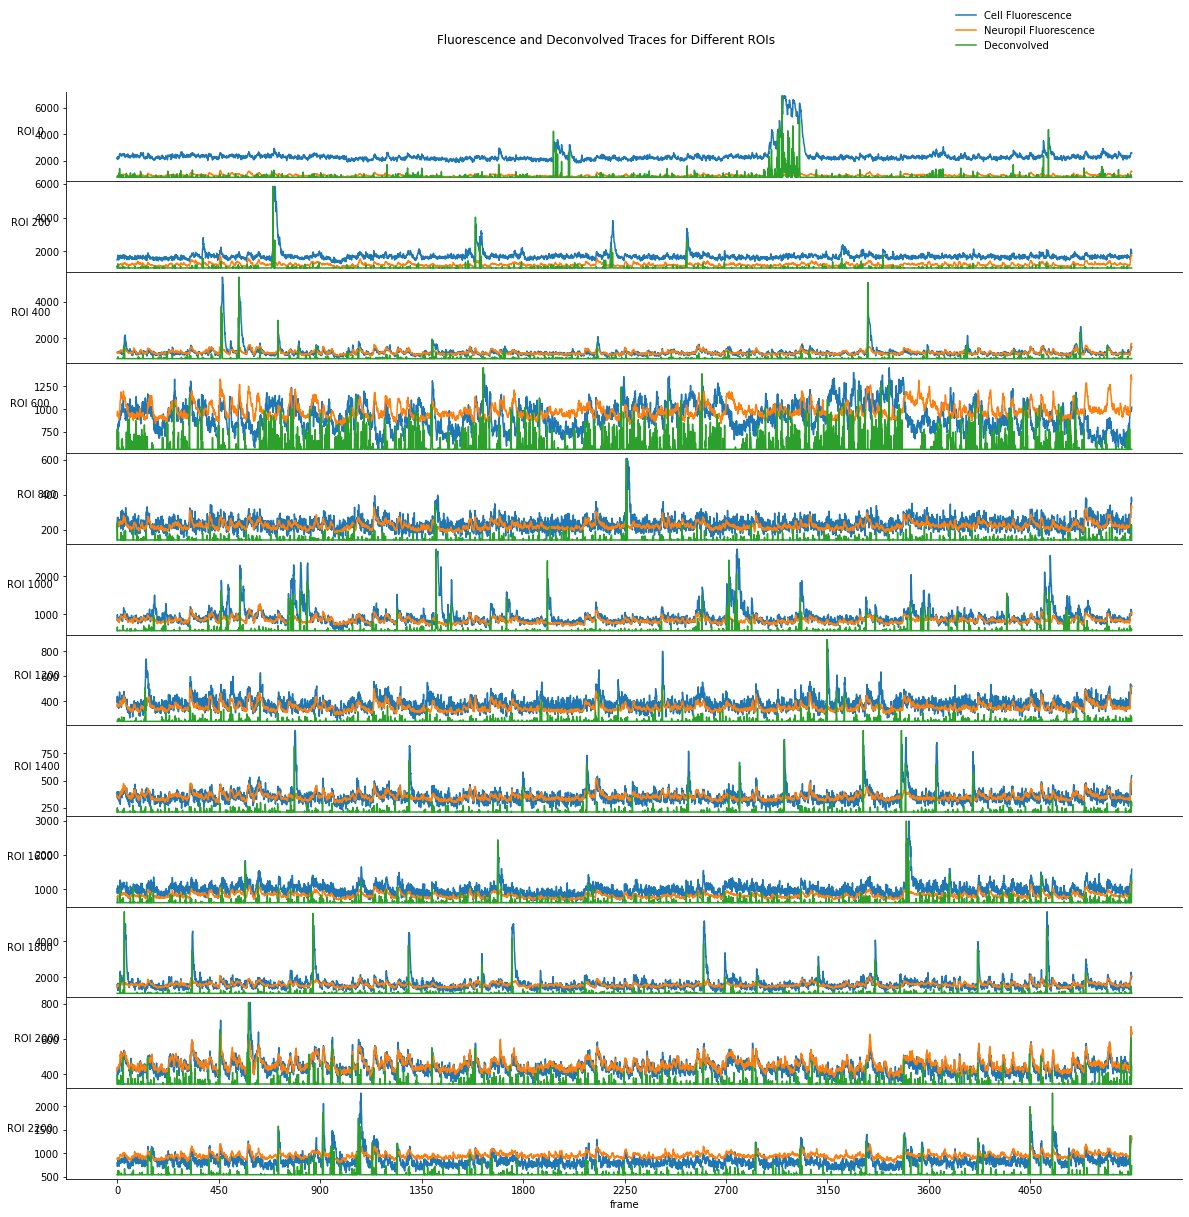

In [17]:
plt.figure(figsize=[20,20])
plt.suptitle("Fluorescence and Deconvolved Traces for Different ROIs", y=0.92);
rois = np.arange(len(f_cells))[::200]
for i, roi in enumerate(rois):
    plt.subplot(len(rois), 1, i+1, )
    f = f_cells[roi]
    f_neu = f_neuropils[roi]
    sp = spks[roi]
    # Adjust spks range to match range of fluroescence traces
    fmax = np.maximum(f.max(), f_neu.max())
    fmin = np.minimum(f.min(), f_neu.min())
    frange = fmax - fmin 
    sp /= sp.max()
    sp *= frange
    plt.plot(f, label="Cell Fluorescence")
    plt.plot(f_neu, label="Neuropil Fluorescence")
    plt.plot(sp + fmin, label="Deconvolved")
    plt.xticks(np.arange(0, f_cells.shape[1], f_cells.shape[1]/10))
    plt.ylabel(f"ROI {roi}", rotation=0)
    plt.xlabel("frame")
    if i == 0:
        plt.legend(bbox_to_anchor=(0.93, 2))